In [ ]:
import json
import datetime
import pandas as pd
import numpy as np
import requests
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib

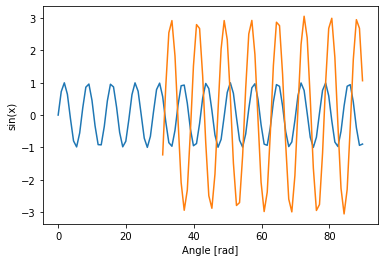

In [96]:
import matplotlib.pylab as plt
days=100
daysperiod=7
x = np.linspace(0, 2*days*(1/daysperiod)*np.pi, days)
y =  pd.Series(np.sin((1/daysperiod)*2*np.pi*x))
p =  3*pd.Series(np.sin((1/3*daysperiod)*2*np.pi*x))
z = y.rolling(window=daysperiod*5).mean()

plt.plot(x,y)
plt.plot(x,p)
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight')
#plt.xlim(0,30)

plt.show()

In [ ]:
plt.show()r = requests.get("https://www.dph.illinois.gov/sitefiles/COVID19/ResurgenceMetrics.json?nocache=1")
hospitalization_json= r.text


data = json.loads(hospitalization_json)
print(data.keys())

In [ ]:

last_update = data['lastUpdatedDate']
last_update
last_update_date = datetime.datetime(last_update['year'], last_update['month'], last_update['day'])
last_update_date


In [ ]:
table = {}
table['date'] = []
table['region'] = []
table['TestPositivity'] = []
table['HospitalAvailability'] = []
table['CLIAdmissions'] = []
data['CLIAdmissions']

In [ ]:
data


In [ ]:
table['date'] = []
table['region'] = []
table['testPositivity'] = []
table['hospitalAvailability'] = []
table['surge'] = []
table['icu'] = []
table['cliAdmissions'] = []
for row in data['TestPositivity']:
    table['date'].append(row['reportDate'])
    table['region'].append(row['regionID'])
    table['testPositivity'].append(row['positivityRollingAvg'])
df_pos = pd.DataFrame({"date":table['date'], "region": table['region'],"testPositivity": table['TestPositivity']})
df_pos = df_pos.set_index(['date', 'region'])
table = {}
table['date'] = []
table['region'] = []
table['testPositivity'] = []
table['hospitalAvailability'] = []
table['surge'] = []
table['icu'] = []
table['cliAdmissions'] = []

for row in data['hospitalAvailability']:
    table['date'].append(row['reportedDate'])
    table['region'].append(row['regionID'])
    table['surge'].append(row['AverageMedSurgAvailPct'])
    table['icu'].append(row['AverageICUAvailPct'])
df_icu_surge = pd.DataFrame({"date":table['date'], "region": table['region'],"surge": table['surge'], "icu": table['icu']})
df_icu_surge = df_icu_surge.set_index(['date', 'region'])
table['date'] = []
table['region'] = []
table['testPositivity'] = []
table['hospitalAvailability'] = []
table['surge'] = []
table['icu'] = []
table['cliAdmissions'] = []

for row in data['cliAdmissions']:
    table['date'].append(row['reportDate'])
    table['region'].append(row['regionID'])
    table['cliAdmissions'].append(row['CLIAdmissionsRA'])
df_cli_admissions = pd.DataFrame({"date":table['date'], "region": table['region'],"cliAdmissions": table['cliAdmissions']})
df_cli_admissions = df_cli_admissions.set_index(['date', 'region'])



In [ ]:
df = df_pos.join(df_icu_surge).join(df_cli_admissions)
df = df.drop_duplicates()
df = df.reset_index()
df = df.pivot(index='date',columns='region')
df.to_csv('regional_hospitalization.csv')

In [ ]:
history = data['HospitalUtilizationResults']
history[0]


In [ ]:
cols = [ 'TotalBeds','TotalOpenBeds','TotalInUseBedsNonCOVID','TotalInUseBedsCOVID','ICUBeds','ICUOpenBeds', 'ICUInUseBedsNonCOVID','ICUInUseBedsCOVID','VentilatorCapacity','VentilatorAvailable','VentilatorInUseNonCOVID','VentilatorInUseCOVID']
table = {}
table['date'] = []
for column in cols:
    table[column] = []
    table[column+'_change'] = []
    table[column+'_change_7day'] = []
    table[column+'_change_14day'] = []
    table[column+'_7day'] = []
    table[column+'_14day'] = []



In [ ]:
for day in history:
    table['date'].append(day['reportDate'])
    for column in cols:
        
        table[column].append(day[column])
        table[column+'_change'].append(0)
        table[column+'_change_7day'].append(0)
        table[column+'_change_14day'].append(0)
        table[column+'_7day'].append(0)
        table[column+'_14day'].append(0)


In [ ]:
df = pd.DataFrame(table)
df['date'] = pd.to_datetime(df['date'])



In [ ]:
for column in cols:
    df[column+'_change'] = df[column].diff(periods=1)


In [ ]:
for column in cols:
    df[column+'_7day'] = df[column].rolling(window=7).mean()
    df[column+'_14day'] = df[column].rolling(window=14).mean()
    df[column+'_change_7day'] = df[column+'_change'].rolling(window=7).mean()
    df[column+'_change_14day'] = df[column+'_change'].rolling(window=14).mean()


In [ ]:
df


In [ ]:
df.to_csv('state_hospitalization.csv')

In [ ]:
df = pd.read_csv('state_hospitalization.csv', index_col=1, parse_dates=True)
df = df.set_index('date')

In [ ]:
df.tail(1)['VentilatorInUseCOVID_7day']

In [ ]:

plt.figure(figsize=(10, 5), dpi=400)
plt.box(on=None)
plt.margins(0)
plt.plot(df.index, df['VentilatorInUseCOVID_7day'], color='#6688cc', label="Ventilator", linewidth=3)
plt.plot(df.index, df['ICUInUseBedsCOVID_7day'], color='#EE3333', label="ICU", linewidth=3)
plt.ylabel("Vents/ICU Beds")
plt.ylim(0)
plt.legend(loc=9).get_frame().set_linewidth(0.0)

ax2 = plt.twinx()
ax2.plot(df.index, df['TotalInUseBedsCOVID_7day'], color='#cca80a', label="Non ICU Bed", linewidth=3)
ax2.set_ylim(0)
ax2.set_ylabel("Non ICU Beds")
ax2.margins(0)

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.legend(loc='best').set_zorder(10)
ax2.legend().get_frame().set_linewidth(0.0)
vent_value = df.tail(1)['VentilatorInUseCOVID_7day'].values[0]
vent_pct = vent_value / df.tail(1)['VentilatorCapacity_7day'].values[0]
icu_value = df.tail(1)['ICUInUseBedsCOVID_7day'].values[0]
icu_pct = icu_value / df.tail(1)['ICUBeds_7day'].values[0]
bed_value = df.tail(1)['TotalInUseBedsCOVID_7day'].values[0]
bed_pct = bed_value / df.tail(1)['TotalBeds_14day'].values[0]
current_date= df.tail(1)['VentilatorInUseCOVID_7day'].index[0]
plt.title('Illinois COVID Hospitalization - '+'{:%b %-d} - {:,} ICU Beds ({:0.1f}%) - {:,} Ventilators ({:0.1f}%) - {:,} Non-ICU Beds ({:0.1f}%)  '.format(current_date,int(icu_value), 100* icu_pct, int(vent_value), 100*vent_pct, int(bed_value), 100*bed_pct))
plt.grid(axis='y', linewidth=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 

plt.savefig('charts/IL Hospitalization.png', bbox_inches='tight')
plt.close()


In [ ]:
print(current_date,int(icu_value), 100* icu_pct, int(vent_value), 100*vent_pct, int(bed_value), 100*bed_pct)

In [ ]:

df.tail(1)['VentilatorInUseCOVID_7day'].index[0]

In [ ]:
current_date
